**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Sentiment_Training

**Retrieving the Dataset**

In [2]:
!wget https://s3.amazonaws.com/fast-ai-nlp/amazon_review_full_csv.tgz
!tar -xvzf amazon_review_full_csv.tgz

--2021-11-24 03:32:06--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_full_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.200.80
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.200.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643695014 (614M) [application/x-tar]
Saving to: ‘amazon_review_full_csv.tgz.7’

amazon_review_full_ 100%[===================>] 613.88M  15.8MB/s    in 64s     

2021-11-24 03:33:11 (9.55 MB/s) - ‘amazon_review_full_csv.tgz.7’ saved [643695014/643695014]

amazon_review_full_csv/
amazon_review_full_csv/train.csv
amazon_review_full_csv/readme.txt
amazon_review_full_csv/test.csv


**Analyzing the Dataset**

*Reading the Dataset*

In [30]:
import pandas

data = pandas.read_csv('amazon_review_full_csv/train.csv', nrows=100000)
data.head()

,3,more like funchuck,"Gave this to my dad for a gag gift after directing ""Nunsense,"" he got a reall kick out of it!"
0,5,Inspiring,I hope a lot of people hear this cd. We need m...
1,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
3,5,Too good to be true,Probably the greatest soundtrack in history! U...
4,5,There's a reason for the price,"There's a reason this CD is so expensive, even..."


In [31]:
len(data)

100000

**Processing**

In [32]:
# Assigning Column Names
data.columns = ["score", "title", "text"]

# Lower Casing
data["title"] = data["title"].str.lower()
data["text"] = data["text"].str.lower()

print(data.score.value_counts())
data.head()

3    20557
5    20161
2    20107
4    19986
1    19189
Name: score, dtype: int64


,score,title,text
0,5,inspiring,i hope a lot of people hear this cd. we need m...
1,5,the best soundtrack ever to anything.,i'm reading a lot of reviews saying that this ...
2,4,chrono cross ost,the music of yasunori misuda is without questi...
3,5,too good to be true,probably the greatest soundtrack in history! u...
4,5,there's a reason for the price,"there's a reason this cd is so expensive, even..."


In [ ]:
!python3 -m spacy download en_core_web_sm

Define Tokenize & Lemma-ize Function & Basic Filtering + Remove Stopwords

In [33]:
import re
import spacy

nlp = spacy.load("en_core_web_sm")
tokenizer = nlp.tokenizer
nlp.Defaults.stop_words |= { "book", "movie", "film" }

def tokenize(text):
  text = re.sub(r'\b(\d+)\b', '', str(text))
  tokenized_text = tokenizer(text)
  based_text = [token.lemma_ for token in tokenized_text if not token.is_punct and not token.is_stop]

  return based_text

Merge Title & Text Columns, Tokenize/Lemma-ize

In [34]:
data.text = data.title + " " + data.text
data.drop(columns='title', inplace=True)

data.text = data.text.apply(tokenize)
data.head()

,score,text
0,5,"[inspire, hope, lot, people, hear, cd, need, s..."
1,5,"[well, soundtrack, read, lot, review, say, wel..."
2,4,"[chrono, cross, ost, music, yasunori, misuda, ..."
3,5,"[good, true, probably, great, soundtrack, hist..."
4,5,"[reason, price, reason, cd, expensive, version..."


Get Most Frequently Appearing Vocabulary + Word Indexing



In [35]:
data["liststring"] = data.text.apply(lambda x: ' '.join(map(str, x)))

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_VOCAB_COUNT = 700

tf_tokenizer = Tokenizer(num_words=MAX_VOCAB_COUNT, oov_token="<unk>")
tf_tokenizer.fit_on_texts(data.liststring.to_list())
word_index = tf_tokenizer.word_index

print(list(word_index)[:10])

['<unk>', 'like', 'good', 'read', 'great', 'well', 'time', 'buy', 'think', 'love']


In [37]:
most_frequent_vocab = pandas.Series(" ".join(data.liststring).split()).value_counts()[:MAX_VOCAB_COUNT]
print(most_frequent_vocab)

like      36091
good      35665
read      34349
great     30606
well      25881
          ...  
seller      855
limit       853
aspect      853
advice      852
genre       850
Length: 700, dtype: int64


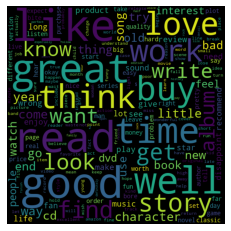

In [38]:
import matplotlib.pyplot as plt
import wordcloud

wcloud = wordcloud.WordCloud(width = 500, height = 500, max_font_size = 100)
wcloud.generate_from_frequencies(most_frequent_vocab.to_dict())
plt.imshow(wcloud)
plt.axis('off')
plt.show()

**Final Processing**

In [13]:
# Multiclass Classification
data['score'] = data.score.apply(lambda x: 0 if x in [1, 2] else x)
data['score'] = data.score.apply(lambda x: 1 if x in [3] else x)
data['score'] = data.score.apply(lambda x: 2 if x in [4, 5] else x)

In [39]:
# Binary Classification
data['score'] = data.score.apply(lambda x: 0 if x in [1, 2, 3] else 1)

In [ ]:
data.score.value_counts()

In [40]:
import numpy

text_list = data.text.to_list()
label_list = numpy.asarray(data.score.to_list())

In [56]:
print(text_list[:1])
print(label_list[:1])

[['inspire', 'hope', 'lot', 'people', 'hear', 'cd', 'need', 'strong', 'positive', 'vibes', 'like', 'great', 'vocal', 'fresh', 'tune', 'cross', 'cultural', 'happiness', 'blue', 'gut', 'pop', 'sound', 'catchy', 'mature']]
[1]


In [57]:
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 50

indexed_text = tf_tokenizer.texts_to_sequences(text_list)
rectangularized = pad_sequences(indexed_text, maxlen=max_length, truncating='post')

tf_text = tensorflow.convert_to_tensor(rectangularized)
print(tf_text)

tf.Tensor(
[[  0   0   0 ...  45   1   1]
 [  0   0   0 ...  38  67   1]
 [  0   0   0 ...   1  49 101]
 ...
 [  0   0   0 ... 208 688   1]
 [ 44   1 320 ...   1   1   1]
 [  0   0   0 ... 186 116   1]], shape=(100000, 50), dtype=int32)


In [43]:
split = round(len(data)*0.7)

training_texts = tf_text[:split]
training_labels = label_list[:split]

validation_texts = tf_text[split:]
validation_labels = label_list[split:]

**Model Training - Categorical**

In [22]:
hot_encoded = tensorflow.keras.utils.to_categorical(training_labels)
validation_hot_encoded = tensorflow.keras.utils.to_categorical(validation_labels)

print(hot_encoded[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [60]:
tensorflow.keras.backend.clear_session()

model = tensorflow.keras.models.Sequential()
model.add(tensorflow.keras.layers.Embedding(MAX_VOCAB_COUNT, 16, input_length=max_length))
model.add(tensorflow.keras.layers.Conv1D(128, 5, activation='relu'))
model.add(tensorflow.keras.layers.GlobalAveragePooling1D())
model.add(tensorflow.keras.layers.Dense(64, activation=tensorflow.nn.relu))
model.add(tensorflow.keras.layers.Dense(32, activation=tensorflow.nn.relu))
model.add(tensorflow.keras.layers.Dense(3, activation=tensorflow.nn.softmax))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            11200     
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                        

In [58]:
tensorflow.keras.backend.clear_session()

model = tensorflow.keras.models.Sequential()
model.add(tensorflow.keras.layers.Embedding(MAX_VOCAB_COUNT, 16, input_length=max_length))
model.add(tensorflow.keras.layers.Conv1D(64, 6, activation=tensorflow.nn.relu))
model.add(tensorflow.keras.layers.GlobalAveragePooling1D())
model.add(tensorflow.keras.layers.Dense(32, activation=tensorflow.nn.relu))
model.add(tensorflow.keras.layers.Dense(16, activation=tensorflow.nn.relu))
model.add(tensorflow.keras.layers.Dense(3, activation=tensorflow.nn.softmax))

sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [29]:
history = model.fit(training_texts, hot_encoded, validation_data=(validation_texts, validation_hot_encoded), epochs=5)

Epoch 1/5
2188/2188 [==============================] - 17s 8ms/step - loss: 0.7608 - accuracy: 0.6684 - val_loss: 0.7910 - val_accuracy: 0.6568
Epoch 2/5
2188/2188 [==============================] - 17s 8ms/step - loss: 0.7530 - accuracy: 0.6724 - val_loss: 0.7786 - val_accuracy: 0.6612
Epoch 3/5
2188/2188 [==============================] - 22s 10ms/step - loss: 0.7444 - accuracy: 0.6772 - val_loss: 0.7834 - val_accuracy: 0.6617
Epoch 4/5
2188/2188 [==============================] - 16s 8ms/step - loss: 0.7361 - accuracy: 0.6810 - val_loss: 0.7809 - val_accuracy: 0.6580
Epoch 5/5
2188/2188 [==============================] - 17s 8ms/step - loss: 0.7268 - accuracy: 0.6862 - val_loss: 0.7806 - val_accuracy: 0.6602


**Model Training - Binary**

In [61]:
tensorflow.keras.backend.clear_session()

model = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Embedding(MAX_VOCAB_COUNT, 16, input_length=max_length),
    tensorflow.keras.layers.GlobalAveragePooling1D(),
    tensorflow.keras.layers.Dense(32, activation='relu'),
    tensorflow.keras.layers.Dense(16, activation='relu'),
    tensorflow.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            11200     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
____________________________________________________

In [46]:
history = model.fit(training_texts, training_labels, validation_data=(validation_texts, validation_labels), epochs=5)

Epoch 1/5
2188/2188 [==============================] - 6s 3ms/step - loss: 0.4514 - accuracy: 0.7808 - val_loss: 0.4644 - val_accuracy: 0.7778
Epoch 2/5
2188/2188 [==============================] - 6s 3ms/step - loss: 0.4498 - accuracy: 0.7814 - val_loss: 0.4621 - val_accuracy: 0.7794
Epoch 3/5
2188/2188 [==============================] - 6s 3ms/step - loss: 0.4496 - accuracy: 0.7814 - val_loss: 0.4636 - val_accuracy: 0.7781
Epoch 4/5
2188/2188 [==============================] - 6s 3ms/step - loss: 0.4484 - accuracy: 0.7826 - val_loss: 0.4655 - val_accuracy: 0.7772
Epoch 5/5
2188/2188 [==============================] - 6s 3ms/step - loss: 0.4468 - accuracy: 0.7840 - val_loss: 0.4663 - val_accuracy: 0.7780
